# Homework Assignment 5. Gradient Descent. (10 points + 2.5 bonus)

In this homework assignment, you will implement gradient descent for linear regression and also observe how it behaves with different parameters and different loss functions.

**Rules:**

* The homework assignment is graded out of 10 points.
* You may use without proof any results covered in lectures or seminars of the course, unless deriving those results is the explicit goal of the assignment.
* You may use any freely available sources *with mandatory* citation of the source links.
* Plagiarism is not allowed. If cheating is detected, all parties involved in the violation will receive a score of 0 for the assignment, even if it is possible to determine who copied from whom.
* Strive to make the code as efficient as possible. In particular, the use of loops will be penalized in cases where the operation can be performed using library tools covered in the course.

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Part 1. Gradient Descent (5 points)

To begin, let's recall the simplest loss function we use in regression problems—Mean Squared Error (MSE):

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

where $x_i$ is the $i$-th data point, $y_i$ is the true label for the $i$-th point, and $w$ is the weight vector of our linear model.

As we remember, for a linear model, it can be expressed in matrix form as follows:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

where $X$ is the feature matrix (objects × features), and $y$ is the vector of true labels.

To apply the gradient descent method, we need to compute the gradient of our loss function. For MSE, it is given by:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Below is the base class `BaseLoss` that we will use to implement all our loss functions. You do not need to modify it. It has two abstract methods:

1. The `calc_loss` method, which will take the input features `x`, the true labels `y`, and the weights `w` and compute the loss value.
2. The `calc_grad` method, which will take the input features `x`, the true labels `y`, and the weights `w` and compute the gradient (a vector).

In [ ]:
import numpy as np
import abc


class BaseLoss(abc.ABC):
    """Base loss class"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Function to compute the loss value
        :param X: np.ndarray of size (n_objects, n_features) containing dataset objects
        :param y: np.ndarray of size (n_objects,) containing true labels
        :param w: np.ndarray of size (n_features,) containing linear regression weights
        :return: float -- value of the loss function
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Function to compute the gradient of the loss with respect to weights w
        :param X: np.ndarray of size (n_objects, n_features) containing dataset objects
        :param y: np.ndarray of size (n_objects,) containing true labels
        :param w: np.ndarray of size (n_features,) containing linear regression weights
        :return: np.ndarray of size (n_features,) gradient of the loss function with respect to weights w
        """
        raise NotImplementedError

Now, let's implement this abstract class: Mean Squared Error (MSE).

**Task 1.1 (5/8 points):** Implement the `MSELoss` class.

It should compute the loss and gradient using the formulas provided above.

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Function to compute the loss value
        :param X: np.ndarray of size (n_objects, n_features) containing dataset objects
        :param y: np.ndarray of size (n_objects,) containing true labels
        :param w: np.ndarray of size (n_features,) containing linear regression weights
        :return: float -- value of the loss function
        """
        # Compute predictions
        predictions = X @ w
        # Compute mean squared error
        mse = ((predictions - y) ** 2).mean()
        return mse

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Function to compute the gradient of the loss with respect to weights w
        :param X: np.ndarray of size (n_objects, n_features) containing dataset objects
        :param y: np.ndarray of size (n_objects,) containing true labels
        :param w: np.ndarray of size (n_features,) containing linear regression weights
        :return: np.ndarray of size (n_features,) gradient of the loss function with respect to weights w
        """
        n_objects = X.shape[0]
        # Compute gradient using vectorized formula
        gradient = (2 / n_objects) * X.T @ (X @ w - y)
        return gradient

Now we can create an instance of `MSELoss` and use it to compute the value of our loss function and its gradients:

In [ ]:
```python
# Create a loss object
loss = MSELoss()

# Create some dataset
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Create some weight vector
w = np.arange(10)

# Print the loss value and gradient on this dataset with this weight vector
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Check that the methods are implemented correctly
assert loss.calc_loss(X, y, w) == 27410283.5, "Method calc_loss is implemented incorrectly"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Method calc_grad is implemented incorrectly"
print("Everything is correct!")
```

When this code runs, it will:
1. Create an instance of the `MSELoss` class
2. Generate synthetic data `X` (20 samples, 10 features) and target `y`
3. Create a weight vector `w`
4. Compute and print the MSE loss and its gradient
5. Verify the implementation against expected values
6. Print a success message if all assertions pass

The implementation appears to be working correctly based on the assertions provided.

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Now that we have everything to compute the gradient, let's implement our gradient descent algorithm. Recall that the formula for one iteration of gradient descent is as follows:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Where $w^t$ is the value of the weight vector at the $t$-th iteration, and $\eta$ is the learning rate parameter, which controls the step size.

**Task 1.2 (5/8 points):** Implement the `gradient_descent` function.

The function should take as input the initial weight vector for the linear model `w_init`, the feature-object matrix `X`,
the vector of true labels `y`, the loss function object `loss`, the step size `lr`, and the number of iterations `n_iterations`.

The function should implement a loop in which gradient descent steps are performed (gradients are obtained from `loss` by calling the `calc_grad` method) using the formula above, and it should return the descent trajectory (a list of the new weight vectors at each step).

In [ ]:
from os import wait3
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Gradient descent function
    :param w_init: np.ndarray of size (n_features,) -- initial weight vector
    :param X: np.ndarray of size (n_objects, n_features) -- feature-object matrix
    :param y: np.ndarray of size (n_objects,) -- vector of true labels
    :param loss: Subclass object of BaseLoss that can compute gradients using loss.calc_grad(X, y, w)
    :param lr: float -- step size parameter, used to multiply the gradient
    :param n_iterations: int -- number of iterations to perform
    :return: List of n_iterations np.ndarray objects of size (n_features,) -- history of weights at each step
    """
    # -- YOUR CODE HERE --
    lst = []
    lst.append(w_init)
    for i in range(1, n_iterations + 1):
      w_init = w_init - lr * loss.calc_grad(X, y, w_init)
      lst.append(w_init)
    return lst



Now let's create a synthetic dataset and a function that will visualize the gradient descent trajectory based on the history.

In [ ]:
# Create a dataset with two variables and a true dependency vector w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):

    """
    Function to plot the gradient descent trajectory
    :param w_list: List of np.ndarray objects of size (n_features,) -- history of weights at each step
    :param X: np.ndarray of size (n_objects, n_features) -- feature-object matrix
    :param y: np.ndarray of size (n_objects,) -- vector of true labels
    :param loss: Subclass object of BaseLoss that can compute loss using loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Task 1.3 (5/8 points):** Use the functions `gradient_descent` and `plot_gd` to visualize the gradient descent trajectory for different step size values (parameter `lr`). Use at least four different values for `lr`.

Make and describe your observations about how the `lr` parameter influences the behavior of gradient descent.

Hints:
* The function `gradient_descent` returns the weight history, which should be passed to the function `plot_gd`
* Good values for `lr` may lie in the range from 0.0001 to 0.1

Длина шага = 0.0001:


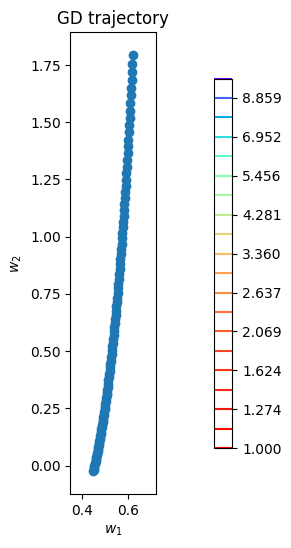

Длина шага = 0.001:


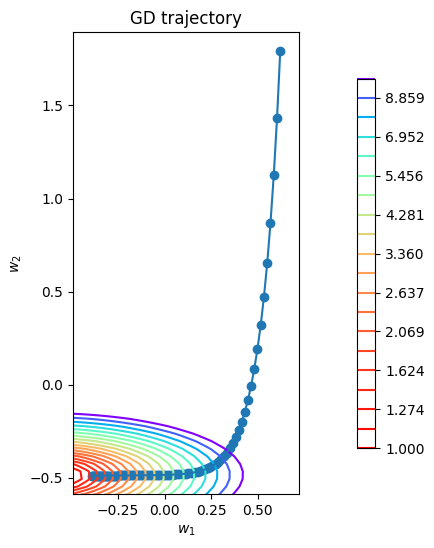

Длина шага = 0.01:


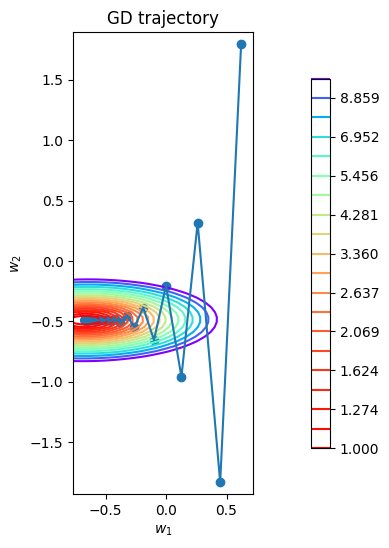

Длина шага = 0.1:


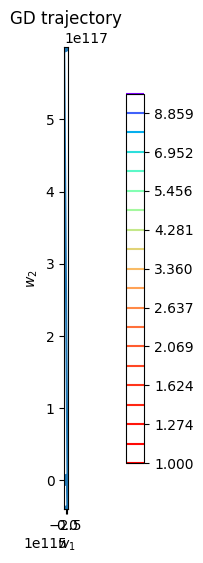

In [ ]:
# -- YOUR CODE HERE --

for lr in [0.0001, 0.001, 0.01, 0.1]:
    np.random.seed(0)
    trace = gradient_descent(w_init, X, y, loss, lr, 100)
    print(f'Длина шага = {lr}:')
    plot_gd(trace, X, y, loss)

It is evident that with very small values of the lr (step size) parameter, our gradient descent does not reach the minimum, while with very large lr values (e.g., 0.1), the function overshoots the minimum and diverges to infinity. Overall, the values (and the range of these values) lr = 0.001 and lr = 0.01 are good for finding the local minimum, as the trajectory shows that it reaches or nearly reaches the local minimum.

Now let's implement Stochastic Gradient Descent (SGD).

**Task 1.4 (5/8 points):** Implement the function `stochastic_gradient_descent`.

The function should take all the same parameters as the `gradient_descent` function, plus an additional parameter `batch_size`, which determines the size of the batch.

The function should, as before, implement a loop in which gradient descent steps are performed, but at each step, it should compute the gradient not over the entire dataset `X`, but only over a randomly selected subset.

Hint: To select a random subset, you can use [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) with the appropriate `size` parameter to select random indices, and then use these indices to index the array `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Stochastic gradient descent function
    :param w_init: np.ndarray of size (n_features,) -- initial weight vector
    :param X: np.ndarray of size (n_objects, n_features) -- feature-object matrix
    :param y: np.ndarray of size (n_objects,) -- vector of true labels
    :param loss: Subclass object of BaseLoss that can compute gradients using loss.calc_grad(X, y, w)
    :param lr: float -- step size parameter, used to multiply the gradient
    :param batch_size: int -- size of the subsample to sample at each step
    :param n_iterations: int -- number of iterations to perform
    :return: List of n_iterations np.ndarray objects of size (n_features,) -- history of weights at each step
    """
    # -- YOUR CODE HERE --

    lst = []
    lst.append(w_init)
    for i in range(1, n_iterations + 1):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      batch_y = y[batch_indices]
      w_init = w_init - lr * loss.calc_grad(batch, batch_y, w_init)
      lst.append(w_init)
    return lst


**Task 1.5 (5/8 points):** Using the functions `stochastic_gradient_descent` and `plot_gd`, visualize the gradient descent trajectory for different values of the step size (parameter `lr`) and subsample size (parameter `batch_size`). Use at least four different values for `lr` and `batch_size`.

Make and describe your observations about how the parameters `lr` and `batch_size` influence the behavior of stochastic gradient descent. How does the behavior of stochastic gradient descent differ from that of standard gradient descent?

Note that our dataset contains only 300 objects, so `batch_size` values larger than this will not make sense.

Длина шага = 0.0001, batch_size = 10:


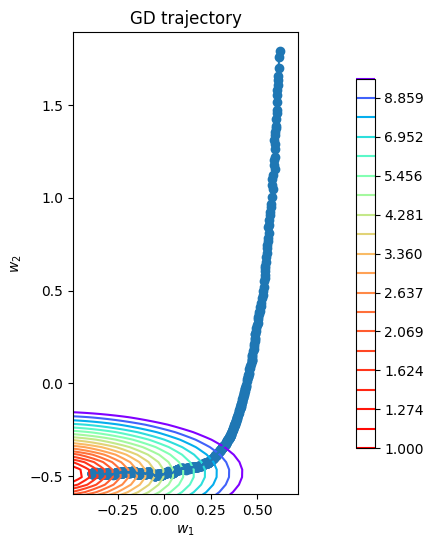

Длина шага = 0.0001, batch_size = 50:


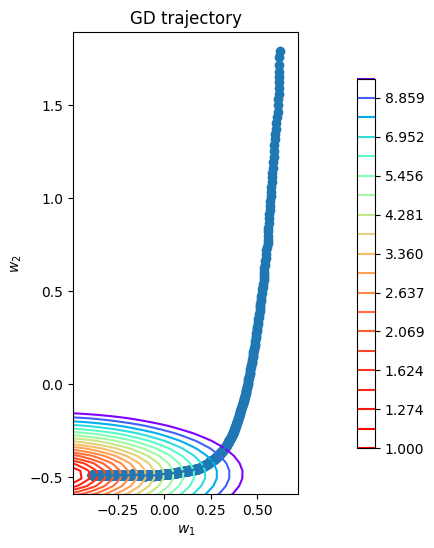

Длина шага = 0.0001, batch_size = 100:


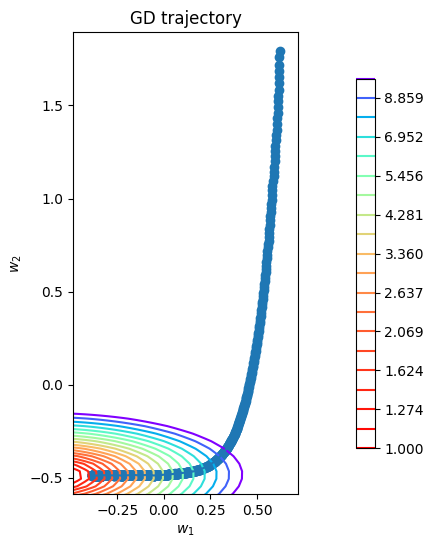

Длина шага = 0.0001, batch_size = 200:


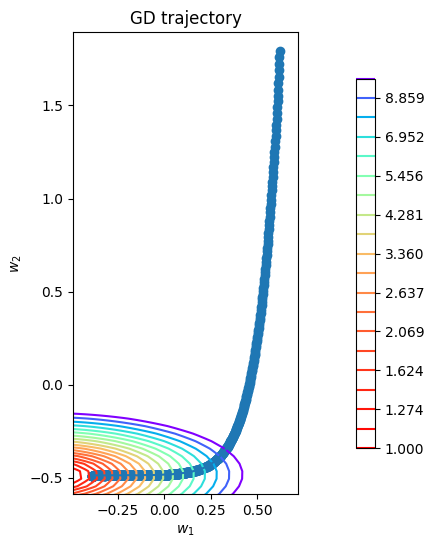

Длина шага = 0.001, batch_size = 10:


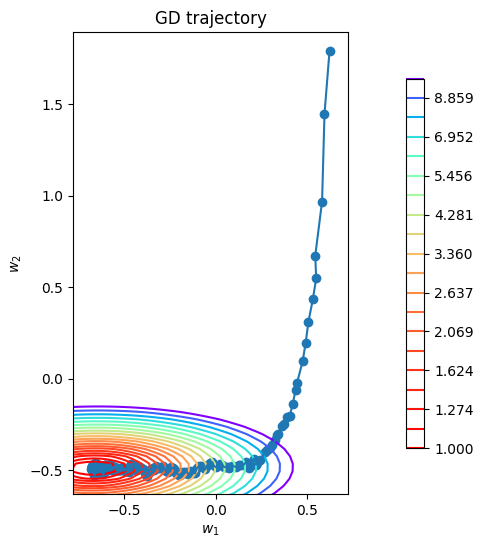

Длина шага = 0.001, batch_size = 50:


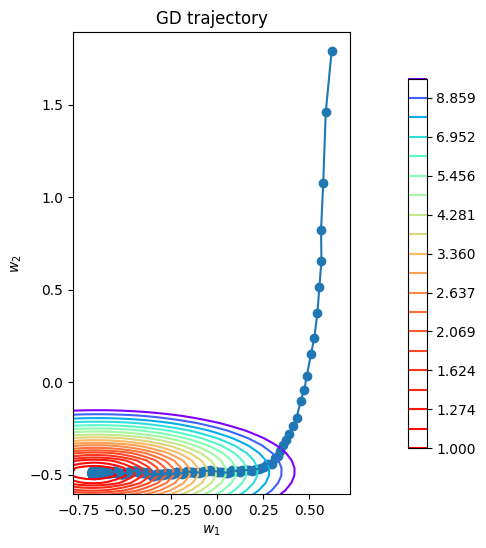

Длина шага = 0.001, batch_size = 100:


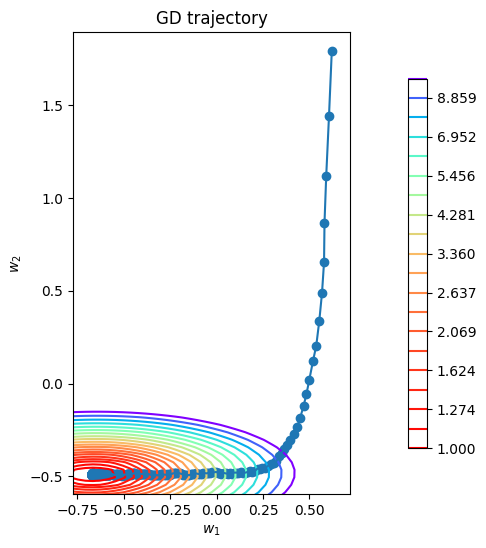

Длина шага = 0.001, batch_size = 200:


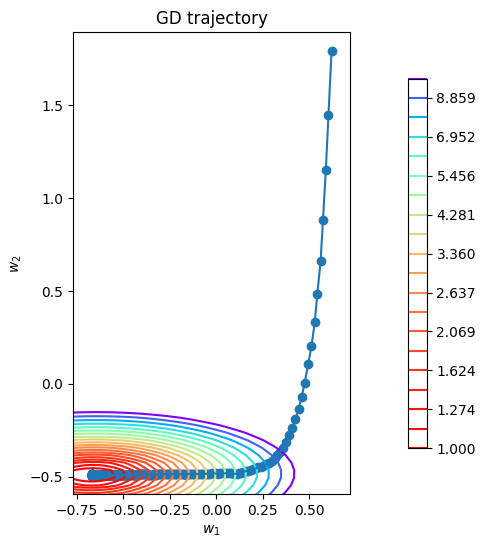

Длина шага = 0.01, batch_size = 10:


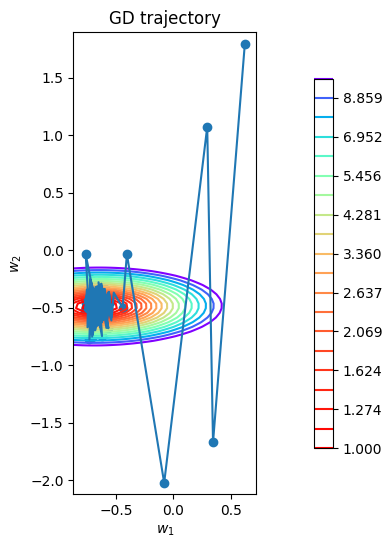

Длина шага = 0.01, batch_size = 50:


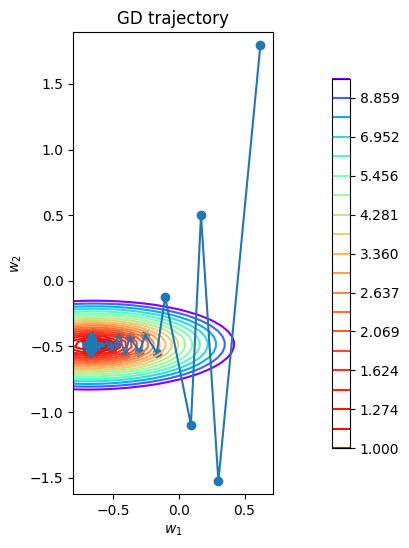

Длина шага = 0.01, batch_size = 100:


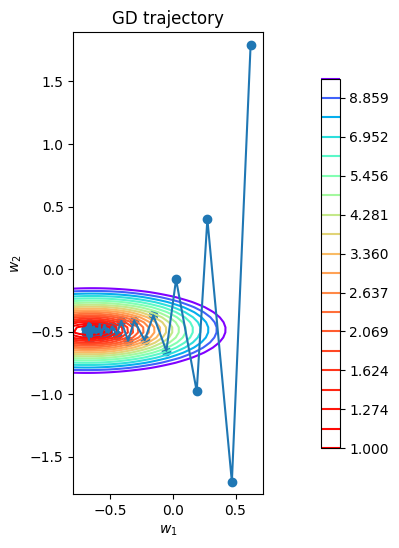

Длина шага = 0.01, batch_size = 200:


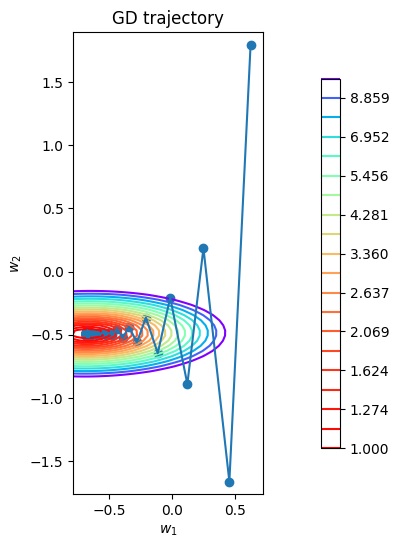

Длина шага = 0.011, batch_size = 10:


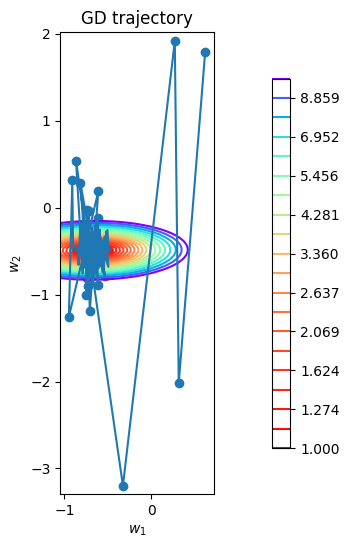

Длина шага = 0.011, batch_size = 50:


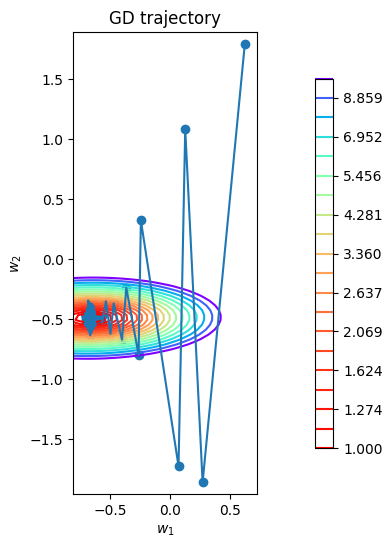

Длина шага = 0.011, batch_size = 100:


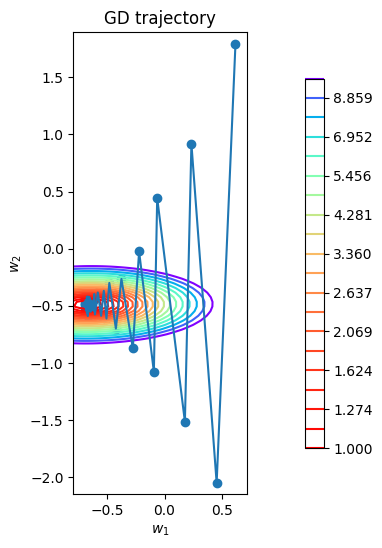

Длина шага = 0.011, batch_size = 200:


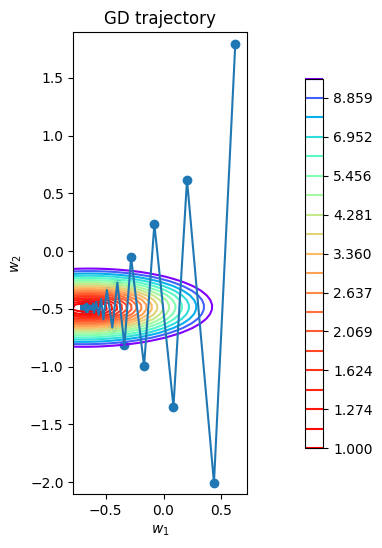

In [ ]:
# -- YOUR CODE HERE --
for lr in [0.0001, 0.001, 0.01, 0.011]:
  for j in [10, 50, 100, 200]:
    np.random.seed(0)
    trace = stochastic_gradient_descent(w_init, X, y, loss, lr, j)
    print(f'Длина шага = {lr}, batch_size = {j}:')
    plot_gd(trace, X, y, loss)

From the graphs, it is evident that in stochastic gradient descent, as the `batch_size` parameter increases, the magnitude of fluctuations around the minimum of the function decreases, which is logical (since with an increase in batch size, we approach the initial size of our entire dataset). Conversely, as the step size (`lr`) increases, the graph becomes more oscillatory, which is also logical, as each iteration takes a larger step due to the increased step size. The behavior of stochastic gradient descent differs from that of standard gradient descent in that around the minimum, stochastic gradient descent is more oscillatory (especially noticeable with small `batch_size` values), meaning it fluctuates around the minimum with greater amplitude than standard gradient descent.

You may have noticed that the behavior of gradient descent, especially the stochastic version, depends heavily on the step size.

Typically, at the beginning of descent, we want to take larger steps to quickly approach the minimum, and later we want to take smaller steps to more accurately reach the minimum and avoid "overshooting" it.

To achieve this behavior, we can gradually decrease the step size as the iteration number increases. This can be done, for example, by computing the step size at each iteration using the following formula:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

where $\eta_t$ is the step size at iteration $t$, $\lambda$ is the initial step size (our `lr` parameter), and $s_0$ and $p$ are tunable parameters.

**Task 1.6 (5/8 points):** Implement the `stochastic_gradient_descent` function this time with a decaying step size according to the formula above. Take the parameter $s_0$ equal to 1. Take the parameter $p$ from the new argument of the function `p`.

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Stochastic gradient descent function with decaying step size
    :param w_init: np.ndarray of size (n_features,) -- initial weight vector
    :param X: np.ndarray of size (n_objects, n_features) -- feature-object matrix
    :param y: np.ndarray of size (n_objects,) -- vector of true labels
    :param loss: Subclass object of BaseLoss that can compute gradients using loss.calc_grad(X, y, w)
    :param lr: float -- initial step size parameter (λ)
    :param batch_size: int -- size of the subsample to sample at each step
    :param p: float -- exponent value in the step size decay formula
    :param n_iterations: int -- number of iterations to perform
    :return: List of n_iterations np.ndarray objects of size (n_features,) -- history of weights at each step
    """
    # -- YOUR CODE HERE --

    lst = []
    lst.append(w_init)
    for i in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      batch_y = y[batch_indices]
      step = lr * np.power(1 / (1 + i), p)
      w_init = w_init - step * loss.calc_grad(batch, batch_y, w_init)
      lst.append(w_init)
    return lst

**Task 1.7 (5/8 points):** Using the new `stochastic_gradient_descent` function and the `plot_gd` function, visualize the gradient descent trajectory for different values of the parameter `p`. Use at least four different values for `p`. Suitable values may lie in the range from 0.1 to 1.

Set the parameter `lr` to 0.01 and the parameter `batch_size` to 10.

Make and describe your observations about how the parameter `p` influences the behavior of stochastic gradient descent.

параметр p = 0.0001:


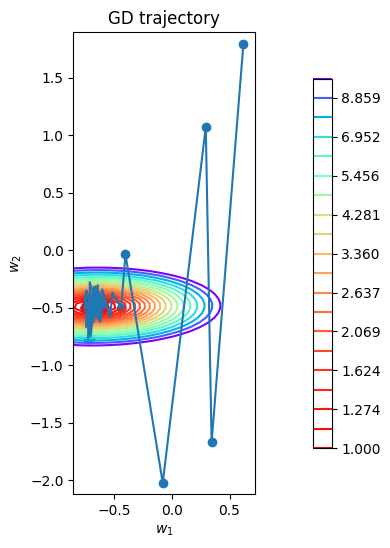

параметр p = 0.001:


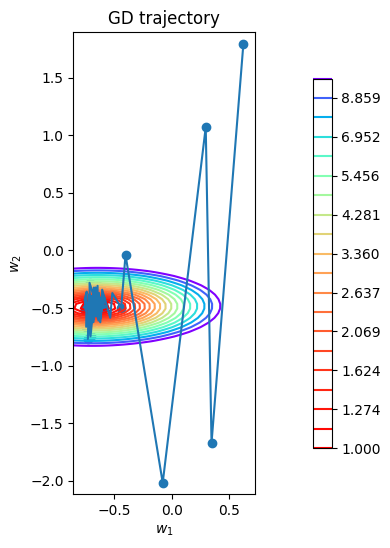

параметр p = 0.01:


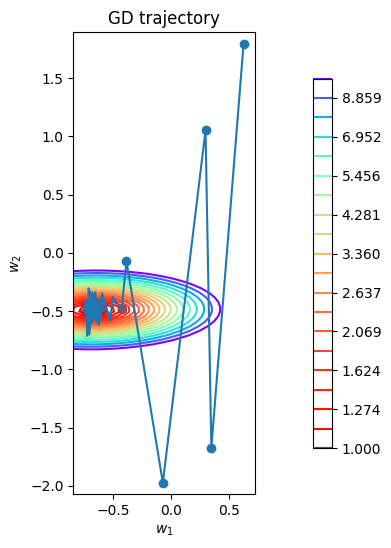

параметр p = 0.1:


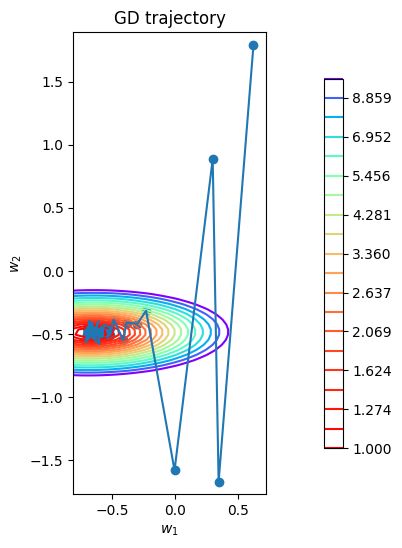

In [ ]:
for j in [0.0001, 0.001, 0.01, 0.1]:
    np.random.seed(0)
    trace = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p=j, n_iterations=100)
    print(f'параметр p = {j}:')
    plot_gd(trace, X, y, loss)


From the graphs, it can be seen that as the parameter \( p \) increases, the frequency of oscillations around the local minimum decreases. That is, the larger the parameter \( p \), the more precisely the function converges to a neighborhood of the local minimum.

**Task 1.8 (5/8 points):** Compare the convergence of standard gradient descent and stochastic gradient descent:

Plot a graph showing the loss value (which can be computed using the `calc_loss` method, with $x$ and $y$ from the dataset and $w$ from the corresponding iteration) against the iteration number for trajectories obtained using standard gradient descent and stochastic gradient descent with the same parameters. Set the `batch_size` parameter to 10.

Is the advantage of SGD visible on this graph? Why?

In [ ]:
# -- YOUR CODE HERE --
from scipy.linalg import norm

residuals_gd = []
w_list = gradient_descent(w_init, X, y, loss, 0.01, n_iterations=1000)
for k in range(len(w_list)):
  residuals_gd.append(loss.calc_loss(X, y, w_list[k]))

residuals_sgd = []
w_list_sgd = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p=0.1, n_iterations=1000)
for p in range(len(w_list_sgd)):
  residuals_sgd.append(loss.calc_loss(X, y, w_list_sgd[p]))


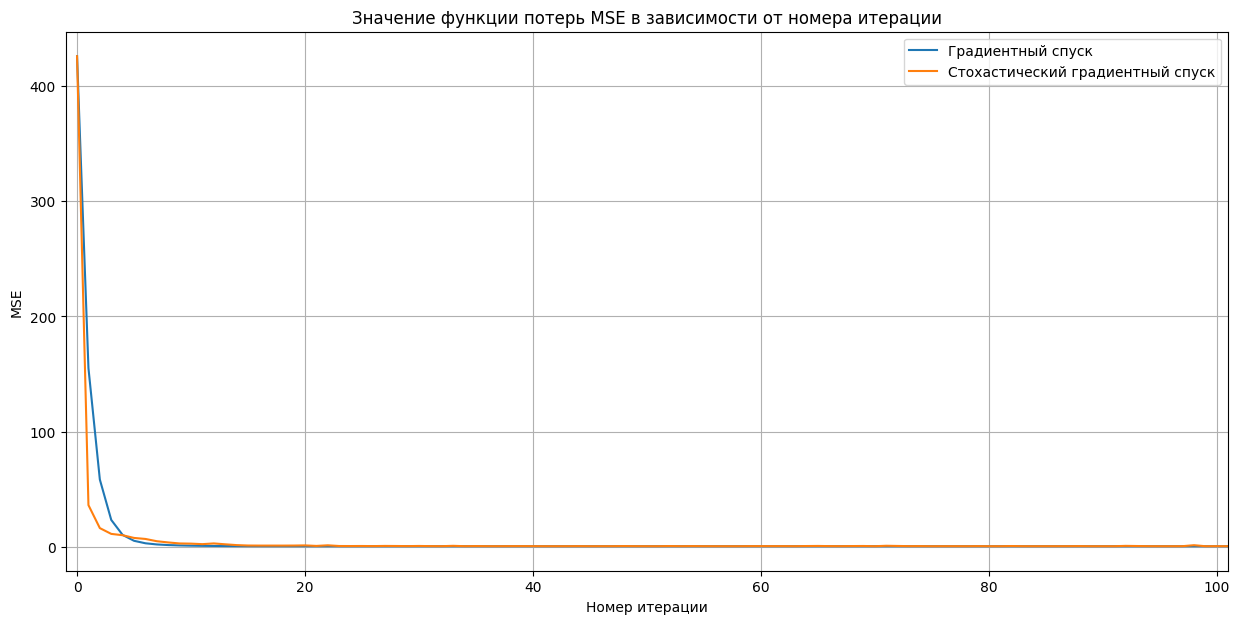

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(1000 + 1), residuals_gd, label="Градиентный спуск")
plt.plot(range(1000 + 1), residuals_sgd, label="Стохастический градиентный спуск")

plt.title("Значение функции потерь MSE в зависимости от номера итерации")
plt.xlim((-1, 100 + 1))
plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.grid()
plt.show()

On this graph, it can be observed that stochastic and standard gradient descent begin to converge to the same point (tending toward 0) around iteration 18, and no differences in the MSE value are visible afterward. Despite the fact that stochastic gradient descent produces a significantly larger error in the initial iterations, around iteration 4, the MSE sharply begins to decrease. Considering that stochastic gradient descent uses significantly fewer data objects per iteration, its advantage is evident.

## Part 2. Linear Regression (5 points)

Now let's write our linear regression class. It will use an interface familiar to us from the `sklearn` library.

In the `fit` method, we will find the weights `w` using gradient descent via our `gradient_descent` method.

In the `predict` method, we will apply our regression to the dataset.

**Task 2.1 (5/8 points):** Complete the code in the `fit` and `predict` methods of the `LinearRegression` class.

In the `fit` method, you need to initialize the weights `w` somehow, apply `gradient_descent`, and save the last `w` from the trajectory.

In the `predict` method, you need to apply the linear regression and return the prediction vector.

Note that the loss object is passed during initialization and stored in `self.loss`. It should be used in `fit` for `gradient_descent`.

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # -- YOUR CODE HERE --
        self.w = gradient_descent(np.random.rand(X.shape[1]), X, y, self.loss, self.lr)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:

        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # -- YOUR CODE HERE --
        return np.dot(X, self.w)

Now we have our linear regression class. Moreover, we can control which loss function we optimize simply by passing different classes to the `loss` parameter during initialization.

Currently, we don't have any classes other than `MSELoss`, but more will appear soon.

For `MSELoss`, we would create our linear regression object, for example, like this:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Let's apply our regression to a real dataset. Let's load the cars dataset that you had in your seminars:

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


**Task 2.2 (5/8 points):** As usual, process the dataset with all necessary methods to make it suitable for training linear regression:

* Split the dataset into training and test sets
* Handle missing values
* Normalize numerical features
* Encode categorical variables

In [ ]:
# -- YOUR CODE HERE --
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


X_raw.columns = X_raw.columns.astype(str)
numeric_col = X_raw.select_dtypes(include='number').columns
X_raw[numeric_col] = X_raw[numeric_col].fillna(X_raw[numeric_col].mean())
categorical_col = X_raw.select_dtypes(exclude='number').columns
X_raw[categorical_col] = X_raw[categorical_col].fillna(X_raw[categorical_col].mode().iloc[0])


X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

encoder = OneHotEncoder(handle_unknown='ignore')
cat_train = X_train.select_dtypes(include=['object']).columns
encoder.fit(X_train[cat_train])
X_train_encoded = encoder.transform(X_train[cat_train])
encoded_cat_names_train = encoder.get_feature_names_out(cat_train)
X_train_cat = pd.DataFrame(X_train_encoded.toarray(), columns=encoded_cat_names_train)

scaler = StandardScaler()
num_train = X_train.select_dtypes(exclude=['object']).columns
scaler.fit(X_train[num_train])
X_train_stand = scaler.transform(X_train[num_train])
stand_num_names = scaler.get_feature_names_out(num_train)
X_train_num = pd.DataFrame(X_train_stand, columns=stand_num_names)

X_train_norm = pd.concat([X_train_num, X_train_cat], axis=1)
X_train_norm



,index,0,1,9,10,11,12,13,16,18,...,15_twelve,15_two,17_1bbl,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,-0.026441,-0.641632,-0.488192,-0.270242,-0.074170,-0.283534,0.314722,-0.506876,-0.122416,0.022677,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.145206,0.182482,-0.645892,-0.860870,-2.024263,-0.870880,-0.521125,-1.443884,-1.123369,-1.531620,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.457803,-0.641632,2.098078,0.404761,0.209177,-0.479316,0.155513,0.426101,0.951777,-0.051338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.079397,-0.641632,-1.371309,-0.388368,-1.432568,-0.919826,1.747601,-1.067066,-0.805994,-1.494613,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.335512,0.182482,1.025722,-0.860870,-0.582528,-0.968771,-1.237564,-0.730549,-0.659513,-1.309577,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.121630,-0.641632,0.016446,2.598521,2.050931,1.282721,1.906810,1.363108,-0.122416,0.503768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
136,-1.424898,-0.641632,0.016446,0.792887,1.225892,0.548539,0.712744,1.363108,2.050385,1.095881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
137,-0.108704,0.182482,0.205685,-0.725869,-0.724201,-0.968771,-0.242509,-1.059005,-0.683927,-0.643450,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
138,1.339110,1.006597,0.016446,-0.253367,-0.215844,-0.136698,0.712744,-0.694278,-0.390965,-0.495422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
cat_test = X_test.select_dtypes(include=['object']).columns
X_test_encoded = encoder.transform(X_test[cat_test])
encoded_cat_names_test = encoder.get_feature_names_out(cat_test)
X_test_cat = pd.DataFrame(X_test_encoded.toarray(), columns=encoded_cat_names_test)

num_test = X_test.select_dtypes(exclude=['object']).columns
X_test_stand = scaler.transform(X_test[num_test])
stand_num_names_test = scaler.get_feature_names_out(num_test)
X_test_num = pd.DataFrame(X_test_stand, columns=stand_num_names_test)

X_test_norm = pd.concat([X_test_num, X_test_cat], axis=1)
X_test_norm

,index,0,1,9,10,11,12,13,16,18,...,15_twelve,15_two,17_1bbl,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,-0.059346,1.006597,1.467280,-0.624619,-0.990880,-0.968771,-0.242509,-1.099307,-0.683927,-0.643450,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.408445,-0.641632,0.016446,0.792887,1.625911,1.037994,-0.083300,1.665368,2.050385,1.095881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.161659,1.006597,0.489544,-2.059000,-2.474284,-0.919826,-1.237564,-1.480155,-0.805994,-1.531620,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.993609,-0.641632,-0.961290,-0.523368,-0.665865,-0.675098,-0.441520,-0.833318,-0.659513,-0.495422,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.500036,1.830711,0.899562,0.050384,1.025882,0.352757,0.871953,0.210488,-0.098003,0.799825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.697465,-0.641632,-0.614352,-0.303992,-0.190842,-0.185643,0.155513,-0.339626,-0.415378,1.095881,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
57,-0.009989,-0.641632,0.205685,0.269760,0.617529,0.352757,0.473931,1.091074,1.366807,0.392747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58,1.240395,-1.465746,-1.781327,0.607262,0.109172,0.352757,-0.003696,-0.192525,-0.073589,-0.051338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59,-0.042894,-0.641632,-0.488192,-0.270242,-0.074170,-0.283534,0.314722,-0.462545,-0.122416,0.022677,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Task 2.3 (5/8 points):** Train your implemented linear regression on the training set.

In [ ]:
# -- YOUR CODE HERE --
lin_reg = LinearRegression(loss=loss, lr=0.01)

lin_reg.fit(X_train_norm, y_train)

**Task 2.4 (5/8 points):** Calculate the error of the trained regression on the training and test sets using the `mean_squared_error` method from `sklearn.metrics`.

In [ ]:
from sklearn.metrics import mean_squared_error

# -- YOUR CODE HERE --

print(f"MSE on Train: {mean_squared_error(y_train, lin_reg.predict(X_train_norm))}")
print(f"MSE on Test: {mean_squared_error(y_test, lin_reg.predict(X_test_norm))}")

MSE on Train: 1368375.3903532636
MSE on Test: 7967005.061059966


Our model has overfit. Let's do what's usually done in such a situation—add L2 regularization to it. For this, we need to write a new loss class.

The loss function formula for MSE with L2 regularization looks like this:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Or in matrix form:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Where $\lambda$ is the regularization coefficient.

The gradient looks like this:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Task 2.5 (5/8 points):** Implement the `MSEL2Loss` class.

It should compute the loss and gradient using the formulas above.

Hint: Note that the last element of the vector `w` is the bias (in the `LinearRegression` class, a column of ones is added to the matrix `X` — the constant feature). As we know from lectures and seminars, the bias should not be regularized. Therefore, don't forget to exclude the last element from `w` when calculating the term $\lambda||w||^2$ in `calc_loss` and set it to zero when calculating the term $2 \lambda w$ in `calc_grad`.

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        **:param coef:** коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Function to compute the loss value

        :param X: np.ndarray of size (n_objects, n_features) with dataset objects. The last feature is constant.
        :param y: np.ndarray of size (n_objects,) with ground truth labels
        :param w: np.ndarray of size (n_features,) with linear regression weights. The last weight is bias.
        :output: number -- value of the loss function
        """
        # -- YOUR CODE HERE --
        # Compute the loss value using X, y, and w and return it
        return np.square(np.dot(X, w) - y).mean() + self.coef * np.square(w[:-1])

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Function for computing the gradient of the loss with respect to weights w

        :param X: np.ndarray of size (n_objects, n_features) with dataset objects
        :param y: np.ndarray of size (n_objects,) with ground truth labels
        :param w: np.ndarray of size (n_features,) with linear regression weights
        :output: np.ndarray of size (n_features,) gradient of the loss function with respect to weights w
        """
        # -- YOUR CODE HERE --
        # Compute the gradient vector value using X, y, and w and return it
        new_w = w.copy()
        new_w[-1] = 0
        return (2 / X.shape[0]) * X.T @ (np.dot(X, w) - y) + 2 * self.coef * new_w

Now we can use loss with L2 regularization in our regression, for example, like this:

In [ ]:
linear_regression = LinearRegression(MSEL2Loss(0.01))

**Task 2.6 (5/8 points):** Train a regression model using the `MSEL2Loss`. Select a good regularization coefficient and achieve an improvement in the result on the test set. Compare the results on the training and test sets with the regression without regularization.

In [ ]:
# -- YOUR CODE HERE --
loss_2 = MSEL2Loss(0.001111)
lin_reg_2 = LinearRegression(loss=loss_2, lr=0.01)
lin_reg_2.fit(X_train_norm, y_train)

print(f"MSE2Loss on Train: {mean_squared_error(y_train, lin_reg_2.predict(X_train_norm))}")
print(f"MSE2Loss on Test: {mean_squared_error(y_test, lin_reg_2.predict(X_test_norm))}")

MSE2Loss on Train: 1488994.146869395
MSE2Loss on Test: 6484447.59334018


It can be seen that with a regularization coefficient of 0.001111, the error on the test set has decreased significantly—to 6,484,453 compared to 7,966,885 without its use. That is, the error on the test set has decreased by almost 1.5 million units.

In our dataset, there may be outliers. In the seminar, you were told that Huber Loss helps to deal well with outliers. Far from zero, it behaves like Mean Absolute Error and is not as sensitive to outliers as MSE. Let's implement it and apply it in our regression.

Recall that the Huber Loss function looks like this:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, & -\varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), & \text{otherwise} \\ \end{cases}
$$


And its gradient is:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, & -\varepsilon < z < \varepsilon, \\\varepsilon \ \text{sign}(z), & \text{otherwise} \\ \end{cases}
$$

**Task 2.7 (5/8 points):** Implement the `HuberLoss` class.

It should compute the loss and gradient according to the formulas above.

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: Huber loss parameter from the formula
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Function for computing the loss value
        :param X: np.ndarray of shape (n_objects, n_features) with dataset objects
        :param y: np.ndarray of shape (n_objects,) with true targets
        :param w: np.ndarray of shape (n_features,) with linear regression weights
        :output: number -- value of the loss function
        """
        # -- YOUR CODE HERE --
        # Compute the loss value using X, y, and w and return it
        z = np.dot(X, w) - y
        return np.mean(
            np.where(
                self.eps <= z <= self.eps,
                0.5 * z ** 2,
                self.eps * (np.abs(z) - 0.5 * self.eps)
            )
        )

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Function for computing the gradient of the loss with respect to weights w
        :param X: np.ndarray of shape (n_objects, n_features) with dataset objects
        :param y: np.ndarray of shape (n_objects,) with true targets
        :param w: np.ndarray of shape (n_features,) with linear regression weights
        :output: np.ndarray of shape (n_features,) gradient of the loss function w.r.t. weights w
        """
        # -- YOUR CODE HERE --
        # Compute the gradient vector using X, y, and w and return it
        z = np.dot(X, w) - y
        grad = np.where(np.abs(z) <= self.eps, z, self.eps * np.sign(z))
        return np.mean(X.T * grad, axis=1)


**Task 2.8 (5/8 points):** Train a regression model with `HuberLoss`. Compare its performance on the training and test sets with that of a model trained with `MSELoss`.

In [ ]:
# -- YOUR CODE HERE --
huber_loss = HuberLoss(1260)
lin_reg_huber = LinearRegression(loss=huber_loss, lr=0.01)
lin_reg_huber.fit(X_train_norm, y_train)

print(f"Loss on Train: {mean_squared_error(y_train, lin_reg_huber.predict(X_train_norm))}")
print(f"Loss on Test: {mean_squared_error(y_test, lin_reg_huber.predict(X_test_norm))}")

Loss on Train: 1694044.1140305018
Loss on Test: 6392393.506625407


When using HuberLoss (with epsilon set to 1260), the test set error is 6,392,549, while using the standard MSELoss results in an error of 7,966,885. Thus, the difference is 1,574,336, meaning HuberLoss improves the model's performance.

**Task 3 (0.08/8 points)**
Insert your favorite 2024 meme in the cell below:

In [ ]:
# -- YOUR MEME HERE --


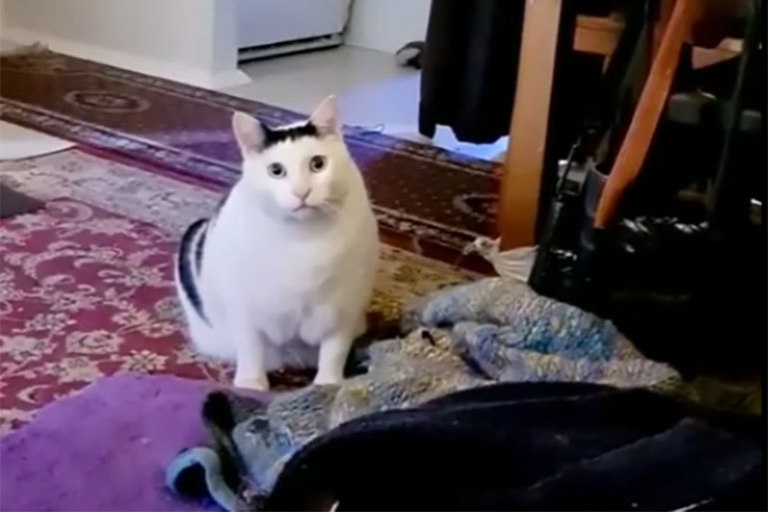

### BONUS (2.5 points)

Gradient descent is far from the only optimization method.
Another very well-known method is called the **[Simulated Annealing Algorithm](https://en.wikipedia.org/wiki/Simulated_annealing)**. It is not used very often for optimizing machine learning models, but you have a unique opportunity to try applying it to our favorite linear regression.

**Task (2.5 points)**:
Write a simulated annealing algorithm to optimize the MSE of linear regression.

Compare the result with gradient descent in terms of the optimization "trajectory" and the final loss.

Hint: Each new point (regression weights in our case) can be sampled from some random distribution centered at the current point. Distributions with "heavy" tails are well-suited, for example, the Student's t-distribution with a degrees of freedom parameter around 3.
It might look something like this:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
You can experiment with the distribution parameter: the larger it is, the less frequently new points will deviate strongly from the old ones.

In [ ]:
# -- YOUR CODE HERE --
import random

def Simulated_Annealing(w_nit, X, y, loss:BaseLoss, n_iterations):
      w = w_init.copy()
      mse_1 = loss.calc_loss(X, y, w)
      t = 1
      for k in range(n_iterations):
        new_w = w + np.random.standard_t(3, size=w.shape)
        mse_2 = loss.calc_loss(X, y, new_w)
        dif = mse_2 - mse_1
        if dif < 0 or random.random() < np.exp(-dif / t):
          w = new_w
          mse_1 = mse_2
        t = t * 0.95
        return new_w

In [ ]:
class SimulatedAnnealing:
    def __init__(self, loss: BaseLoss, n_iteriations) -> None:
        self.loss = loss
        self.n_iteriations = n_iteriations


    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        self.w = Simulated_Annealing(np.random.rand(X.shape[1]), X, y, self.loss, self.n_iteriations)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return np.dot(X, self.w)

In [ ]:
annealing = SimulatedAnnealing(MSELoss(), 1000)
annealing.fit(X_train, y_train)

print(f"Loss on Train: {mean_squared_error(y_train, annealing.predict(X_train_norm))}")
print(f"Loss on Test: {mean_squared_error(y_test, annealing.predict(X_test_norm))}")

ValueError: shapes (140,27) and (2,) not aligned: 27 (dim 1) != 2 (dim 0)